# Classical cell counter for light microscopy
Contents:
1. Packages
2. Useful functions
3. Image loading
4. Algorithm for counting
5. Visual counting results
6. Histogram for cells sizes

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage.exposure import equalize_hist, adjust_gamma
import cv2

## Useful functions

In [2]:
def clip(x): 
    return np.clip(x, a_min=0, a_max=6*np.std(x))

def norm(x):
    x = clip(x)
    return (x) / ( np.max(x))

def binary_mask(x, treshold=None, sigmas = 2):
    if treshold:
        return norm(x) > treshold
    else:
        return norm(x) > sigmas*np.std(norm(x))
    
def remove_big_objects(bw, max_size):
    return bw^remove_small_objects(bw, min_size = max_size)

## Image loading

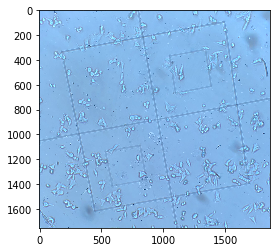

In [27]:
img = cv2.imread('img/example2.png') # picture for example, more images in 'img/data' folder
plt.imshow(norm(img))
plt.show()

# Algorithm

In [ ]:
# making an array from the image
src_gray = np.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), dtype=np.float32)
cell =  np.asarray(src_gray, dtype=np.float32)

# important parameters
binary_treshold = 0.3
min_size = 16 # 16 px area is minimal

# Changing contrast
cell = adjust_gamma(cell, 4)

# Binary tresholded image
clean_cell_bw = remove_big_objects(
            remove_small_objects(
                            binary_mask(cell, 0.42),
                            min_size=120
                        ),
                max_size=1800)

# count cells
labeled = label(clean_cell_bw, background=0)

## Visual counting results

66


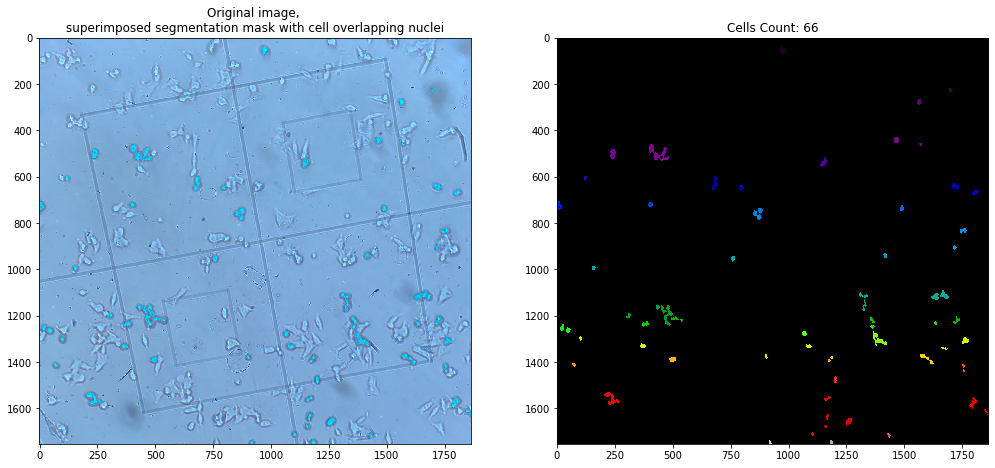

In [29]:
plt.figure(figsize = (17,17))

rgb = np.zeros(list(cell.shape)+[3], dtype = np.uint8)
rgb = np.copy(img)

# color binary mask region
rgb[:,:, 0] =  rgb[:,:, 0] + clean_cell_bw*cell *255 

plt.subplot(1,2,1)
plt.title('Original image, \n superimposed segmentation mask with cell overlapping nuclei ')
plt.imshow(rgb)

plt.subplot(1,2,2)
plt.title('Cells Count: '+ str(np.max(labeled)))

# count the number of cells
N = np.max(labeled)

plt.imshow(labeled, cmap='nipy_spectral')

print(N)

## Histogram for cells sizes

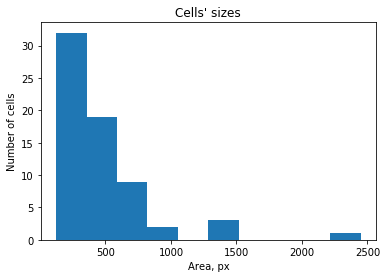

In [30]:
cells_sizes = [x.area for x in regionprops(labeled)]
%matplotlib inline
plt.hist(cells_sizes, density=False, bins=10)
plt.ylabel('Number of cells')
plt.xlabel('Area, px')
plt.title('Cells\' sizes')
plt.show()